训练

In [ ]:
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import pandas as pd
from lightning.pytorch.callbacks import ModelCheckpoint
from dataset import ElectricityDataModule
#from tpa_lstm import TPALSTM
from tpa_lstm import TPALSTM
import torch
from torch import nn
from lightning.pytorch.callbacks import EarlyStopping

#data_df = pd.read_csv('ture_cd.csv')
#data_df = pd.read_csv('testdata.csv')
data_df = pd.read_csv('hpcmci.csv')
#data_df.drop(columns=['date'],inplace=True)
num_features = data_df.shape[1]
data_splits = {
        "train": 0.7,
        "val": 0.15,
        "predict": 0.15
    }
pred_horizons = [12,24,48,96]
pred_horizon = 12
batch_size=32
hid_size = 64
n_layers = 3
num_filters = 3

time_window=10
time_windows=[96]
num_y=1

for pred_horizon in pred_horizons:
    run_name = f"{pred_horizon}-仿真-allY"
    for time_window in time_windows:

        elec_dm = ElectricityDataModule(
            dataset_splits=data_splits,
            batch_size=batch_size,
            window_size=time_window,
            pred_horizon=pred_horizon,
            data_style="custom",
            data=data_df,
            num_y=num_y
        )

        name = f'{run_name}-TPA-LSTM-'+str(time_window)

        

        checkpoint_loss_tpalstm = ModelCheckpoint(
            dirpath=f"checkpoints/{run_name}",
            filename=name,
            save_top_k=1,
            monitor="val/loss",
            mode="min"
        )


        early_stop_callback = EarlyStopping(
            monitor='val/loss',  # 指定监控指标
            min_delta=0.00,  # 指标提升的最小变化量
            patience=2,  # 没有提升时的等待轮数
            verbose=True,
            mode='min'
        )

        tpalstm_trainer = pl.Trainer(
            max_epochs=100,
            # accelerator='gpu',
            callbacks=[checkpoint_loss_tpalstm,early_stop_callback],
            #callbacks=[checkpoint_loss_tpalstm],
            strategy='auto',
            devices=1,
            # logger=wandb_logger_tpalstm
        )

        tpa_lstm = TPALSTM(
            input_size=num_features,
            hidden_size=hid_size,
            output_horizon=pred_horizon,
            num_filters=num_filters,
            obs_len=time_window,
            n_layers=n_layers,
            num_y=num_y,
            lr=1e-3,
            #num_heads=2
        )
        # tpa_lstm.eval()
        # input=torch.rand(batch_size,time_window,num_features)
        # out=tpa_lstm(input)
        
        tpalstm_trainer.fit(tpa_lstm, elec_dm)

预测

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # 解决MacOS系统下的问题
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import pandas as pd
from lightning.pytorch.callbacks import ModelCheckpoint
from dataset import ElectricityDataModule
from tpa_lstm import TPALSTM
#from tpa_lstm import TPALSTM
import torch
from torch import nn
from lightning.pytorch.callbacks import EarlyStopping

def MAE(ypred, ytrue):
    absolute_errors = torch.abs(ypred - ytrue)
    # 求和得到总的MAE
    mae = torch.sum(absolute_errors)
    # 如果有多个batch或多个样本，需要进行均分
    temp=1
    for i in range(len(ypred.size())):
        temp=temp*ypred.size(i)
    mae = mae / temp  # 假设第一维是batch size
    return mae
                      
tpalstm_trainer = pl.Trainer(
    max_epochs=100,
    # accelerator='gpu',
    #callbacks=[checkpoint_loss_tpalstm],
    strategy='auto',
    devices=1,
    # logger=wandb_logger_tpalstm
)

MSE = nn.MSELoss()


  


#data_df = pd.read_csv('ture_cd.csv')
#data_df = pd.read_csv('testdata.csv')
Yture1=[]
Ypred1=[]
mse1=[]
mae1=[]
pred_horizons=[12,24,48,96]
data_df = pd.read_csv('hpcmci.csv')
num_features = data_df.shape[1]
num_y=1
for pred_horizon in pred_horizons:
    
    data_splits = {
            "train": 0.7,
            "val": 0.15,
            "predict": 0.15
        }
    #red_horizon = 12
    batch_size=32
    hid_size = 64
    n_layers = 3
    num_filters = 3

    time_window=10
    time_windows=[96]
    run_name = f"{pred_horizon}-仿真-allY"    

    for time_window in time_windows:

        folder_path="仿真/TPA-LSTM-"+str(pred_horizon)
        elec_dm = ElectricityDataModule(
            dataset_splits=data_splits,
            batch_size=batch_size,
            window_size=time_window,
            pred_horizon=pred_horizon,
            data_style="custom",
            data=data_df,
            num_y=num_y
        )
        
        elec_dm.setup("predict")

        pred_dl = elec_dm.predict_dataloader()

        name = f'{run_name}-TPA-LSTM-'+str(time_window)
        run_to_load = run_name
        model_path = f"checkpoints/{run_to_load}/{name}.ckpt"
        tpa_lstm = TPALSTM.load_from_checkpoint(model_path)
        y_pred = tpalstm_trainer.predict(tpa_lstm, pred_dl)

        batch_idx = 0

        Yture=[]
        Ypred=[]


        batch_idx = 0
        for i, batch in enumerate(pred_dl):
            inputs, labels = batch
            X, ytrue = inputs[batch_idx][:, -1],  labels.squeeze()
            ypred = y_pred[i].squeeze()
            Yture.append(ytrue)
            Ypred.append(ypred)
            #X = X.cpu().numpy()
        if len(Yture[-1].size())!=len(Yture[-2].size()):
            Yture[-1]=Yture[-1].unsqueeze(0)
        if len(Ypred[-1].size())!=len(Ypred[-2].size()):
            Ypred[-1]=Ypred[-1].unsqueeze(0)
        Yture=torch.cat(Yture,dim=0)
        Ypred=torch.cat(Ypred,dim=0)
        #plt.plot(Yture, label='Y-val', color='green')
        
        mse=MSE(Ypred,Yture)
        mae=MAE(Ypred,Yture)
        print(mse)
        print(mae)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        torch.save(Yture,folder_path+'/true.npy')
        torch.save(Ypred,folder_path+'/pred.npy')


HPCMCI
HPCMCI-LSTM
TPA-LSTM
LSTM
Informer


C:\Users\孙靖贺\AppData\Local\Temp\ipykernel_9144\1377867261.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('plasma', 6)  # 'hsv'是颜色映射的一种


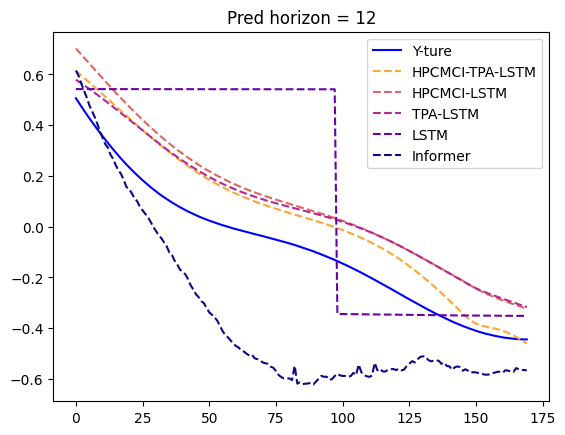

HPCMCI
HPCMCI-LSTM
TPA-LSTM
LSTM
Informer


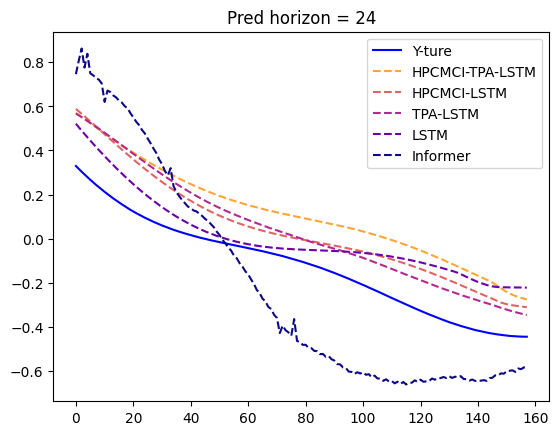

HPCMCI
HPCMCI-LSTM
TPA-LSTM
LSTM
Informer


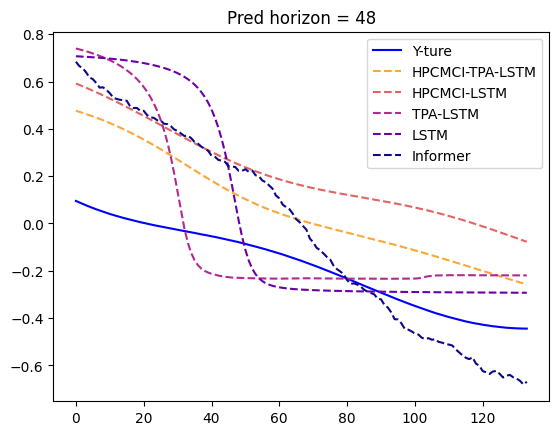

HPCMCI
HPCMCI-LSTM
TPA-LSTM
LSTM
Informer


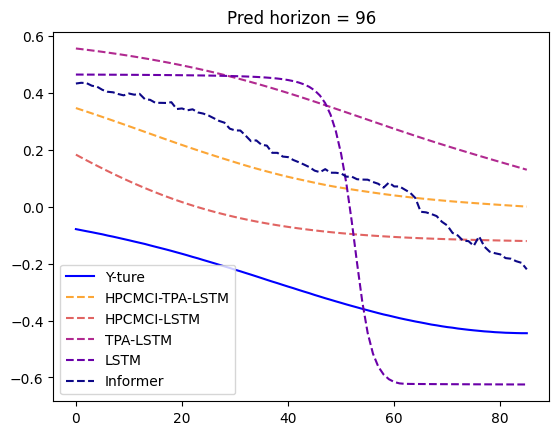

In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # 解决MacOS系统下的问题
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import pandas as pd
from lightning.pytorch.callbacks import ModelCheckpoint
from dataset import ElectricityDataModule
from tpa_lstm import TPALSTM
#from tpa_lstm import TPALSTM
import torch
import numpy as np
from torch import nn
from lightning.pytorch.callbacks import EarlyStopping

#画图

Yture1=[]
Ypred1=[]
mse1=[]
mae1=[]
#12,24,48,
pred_horizons=[12,24,48,96]
num_y=1
models=['HPCMCI','HPCMCI-LSTM','TPA-LSTM','LSTM','Informer']
#models=['Informer']
for pred_horizon in pred_horizons:
    color_cycle = plt.cm.get_cmap('plasma', 6)  # 'hsv'是颜色映射的一种
    iii=0
    Yture=torch.load('仿真/HPCMCI-LSTM-'+str(pred_horizon)+'/true.npy')
    lenth=Yture.size(0)
    Yture=torch.load('仿真/HPCMCI-'+str(pred_horizon)+'/true.npy')
    plt.title('Pred horizon = '+str(pred_horizon))
    # 绘制真实值曲线
    plt.plot(Yture[-lenth:,-1], label='Y-ture', color='blue')
    for model in models:
            print(model)
            color=color_cycle(4-iii)
            if model=='Informer':
                Ypred=np.load('仿真/'+model+'-'+str(pred_horizon)+'/pred.npy')
                Ypred=Ypred[-lenth:,-1,0]+0.5
            else:
                Ypred=torch.load('仿真/'+model+'-'+str(pred_horizon)+'/pred.npy')
                Ypred=Ypred[-lenth:,-1]
            # 绘制预测值曲线
            if model=='HPCMCI':
                  model='HPCMCI-TPA-LSTM'
            plt.plot(Ypred, label=model, linestyle='--',color=color)
            iii=iii+1
            # 添加图例
    plt.legend()
            # 显示图表
    plt.show()

